In [1]:
%%time
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.dates as mdates
import pandas as pd
from sklearn import linear_model
import matplotlib
from matplotlib import ticker
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
import seaborn as sns # Convention alias for Seaborn
from patsy import dmatrices
from pingouin import ancova

from sklearn.metrics import mean_squared_error


CPU times: user 5.23 s, sys: 5.32 s, total: 10.5 s
Wall time: 26.5 s


In [2]:
yearmin = 2015
wrt = '1'#or 1
savefig=False

In [3]:
#region = 'amundsen' #'basin','nansen','amundsen'
region = 'basin'

In [4]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    fit = fit-fit.mean(dim=dim)
    return da - fit

def clim(ds):
    ds_detr = detrend_dim(ds,"time")
    ds_clim_mean = ds_detr.groupby("time.month").mean("time")
    ds_clim_std = ds_detr.groupby("time.month").std("time")
    ds_anom = ds.groupby("time.month") - ds_clim_mean
    return ds_clim_mean, ds_clim_std, ds_anom

In [5]:
plot_path  = '/p/home/jusers/mueller29/juwels/EPICA/plots/figures_paper/'

In [6]:
data_path = '/p/project/chhb19/mueller29/'
regional_path = '/p/scratch/chhb19/mueller29/regional/'

ECR=xr.open_mfdataset((regional_path+'wpbp.fesom.'+region+'.20*'+str(wrt)+'M.nc'))['ECR'].resample(time="1MS").mean(dim="time")
EKE=xr.open_mfdataset((regional_path+'KE.fesom.'+region+'.20*'+str(wrt)+'M.nc'))['EKE'].resample(time="1MS").mean(dim="time")

#data=xr.open_dataset((data_path+'wpbp/wpbp.fesom.nc'))
#data.to_netcdf(data_path+'curl_std_mean_all.nc')
#ice=xr.open_dataset(data_path+'curl_std_mean_AO40/ice_mean_std.nc')
MLD2=xr.open_dataset(regional_path+'MLD2.fesom.timeseries.'+region+'.nc')['MLD2'].resample(time="1MS").mean(dim="time")
N2=xr.open_dataset(regional_path+'N2.fesom.timeseries.'+region+'.nc')['N2'].resample(time="1MS").mean(dim="time")
a_ice=xr.open_dataset(regional_path+'a_ice.fesom.timeseries.'+region+'.nc')['a_ice'].resample(time="1MS").mean(dim="time")
iceoce=xr.open_dataset(regional_path+'iceoce.fesom.timeseries.'+region+'.nc')['iceoce'].resample(time="1MS").mean(dim="time")
temp=xr.open_dataset(regional_path+'temp.fesom.timeseries.'+region+'.nc')['temp'].resample(time="1MS").mean(dim="time")
salt=xr.open_dataset(regional_path+'salt.fesom.timeseries.'+region+'.nc')['salt'].resample(time="1MS").mean(dim="time")
atmoce=xr.open_dataset(regional_path+'atmoce.fesom.timeseries.'+region+'.nc')['atmoce'].resample(time="1MS").mean(dim="time")
thdgr=xr.open_dataset(regional_path+'thdgr.fesom.timeseries.'+region+'.nc')['thdgr'].resample(time="1MS").mean(dim="time")


In [7]:
MLD2 = MLD2.isel(time=MLD2.time.dt.year>=yearmin)
N2 = N2.isel(time=N2.time.dt.year>=yearmin)
a_ice = a_ice.isel(time=a_ice.time.dt.year>=yearmin)
iceoce = iceoce.isel(time=iceoce.time.dt.year>=yearmin)
temp = temp.isel(time=temp.time.dt.year>=yearmin)
salt = salt.isel(time=salt.time.dt.year>=yearmin)
ECR = ECR.isel(time=ECR.time.dt.year>=yearmin)
EKE = EKE.isel(time=EKE.time.dt.year>=yearmin)
atmoce = atmoce.isel(time=atmoce.time.dt.year>=yearmin)
thdgr = thdgr.isel(time=thdgr.time.dt.year>=yearmin)

stress = atmoce+iceoce

/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [8]:
vars = ['EKE','ECR','MLD2','N2','iceoce','atmoce','a_ice','temp','salt','thdgr','stress']
for var in vars:
    ex_stri=var+'_clim,'+var+'_std,'+var+'_anom=clim('+var+')'
    exec(ex_stri)

In [9]:
t_MLD2=np.arange(str(yearmin)+'-01', '2021-02', dtype='datetime64[M]')
z = ECR.nz.values
z1 = EKE.nz1.values
t = ECR.time

In [10]:
top = 0
bottom = 50
iz = (z1>=top)&(z1<=bottom)
iz1 = (z>=top)&(z<=bottom)
import itertools
vars = ['a_ice','ECR','N2','stress']
fi = True
EKE_anom_mean=EKE_anom[:,iz].mean(axis=1)
ECR_anom_mean=ECR_anom[:,iz1].mean(axis=1)
N2_anom_mean=N2_anom[:,iz1].max(axis=1)

tmp = np.stack([EKE_anom_mean.values,ECR_anom_mean.values,a_ice_anom.values,N2_anom_mean.values,stress_anom.values])
df = pd.DataFrame(tmp.T, columns = ['EKE','ECR','a_ice','N2','stress'])
size=1000

model_lin = linear_model.LinearRegression(fit_intercept=True)
model_lasso = linear_model.Lasso(alpha=0.1)


stuff = np.arange(0,len(vars),1)
for L in range(1,len(stuff) + 1):
    tmp_vars = []
    for subset in itertools.combinations(stuff, L):
        list_of_integers = list(int(item) for item in subset)
        vars_tmp = list(vars[i] for i in list_of_integers)
        tmp_vars.append(vars_tmp)
        X = df[vars_tmp]
        y = df['EKE']
        tmp_fit = model_lin.fit(X, y)
        ve=tmp_fit.score(X, y)
        
        print(str(vars_tmp)+' '+str(int(np.round(100*ve)))+'%')

['a_ice'] 62%
['ECR'] 5%
['N2'] 2%
['stress'] 17%
['a_ice', 'ECR'] 62%
['a_ice', 'N2'] 62%
['a_ice', 'stress'] 74%
['ECR', 'N2'] 7%
['ECR', 'stress'] 23%
['N2', 'stress'] 19%
['a_ice', 'ECR', 'N2'] 63%
['a_ice', 'ECR', 'stress'] 75%
['a_ice', 'N2', 'stress'] 74%
['ECR', 'N2', 'stress'] 25%
['a_ice', 'ECR', 'N2', 'stress'] 75%


In [11]:
vars = ['a_ice','ECR','N2','stress']
fi = True
EKE_annual=EKE_anom[:,iz].mean(axis=1).groupby("time.year").mean("time")
ECR_annual=ECR_anom[:,iz1].mean(axis=1).groupby("time.year").mean("time")
a_ice_annual=a_ice_anom.groupby("time.year").mean("time")
N2_annual=N2_anom[:,iz1].max(axis=1).groupby("time.year").mean("time")
stress_annual=stress_anom.groupby("time.year").mean("time")

tmp2 = np.stack([EKE_annual.values,ECR_annual.values,a_ice_annual.values,N2_annual.values,stress_annual.values])
df2 = pd.DataFrame(tmp2.T, columns = ['EKE','ECR','a_ice','N2','stress'])

stuff = np.arange(0,len(vars),1)
for L in range(1,len(stuff) + 1):
    tmp_R2 = []
    tmp_vars = []
    for subset in itertools.combinations(stuff, L):
        list_of_integers = list(int(item) for item in subset)
        vars_tmp = list(vars[i] for i in list_of_integers)
        tmp_vars.append(vars_tmp)
        X = df2[vars_tmp]
        y = df2['EKE']
        regr = linear_model.LinearRegression(fit_intercept=True)
        tmp_fit = regr.fit(X, y)
        tmp_R2.append(tmp_fit.score(X, y))
        ve=tmp_fit.score(X, y)
        

        print(str(vars_tmp)+' '+str(int(np.round(100*ve)))+'%')


['a_ice'] 77%
['ECR'] 44%
['N2'] 27%
['stress'] 47%
['a_ice', 'ECR'] 83%
['a_ice', 'N2'] 80%
['a_ice', 'stress'] 81%
['ECR', 'N2'] 65%
['ECR', 'stress'] 88%
['N2', 'stress'] 51%
['a_ice', 'ECR', 'N2'] 87%
['a_ice', 'ECR', 'stress'] 94%
['a_ice', 'N2', 'stress'] 81%
['ECR', 'N2', 'stress'] 100%
['a_ice', 'ECR', 'N2', 'stress'] 100%


In [12]:
SMALL_SIZE = 8
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


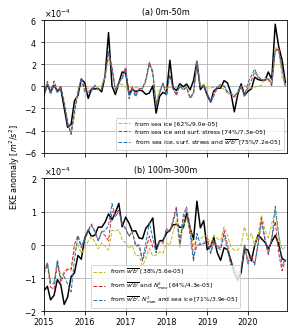

In [70]:
%matplotlib inline

fi = True


vars = ['a_ice','ECR','N2','stress']
n_str = ['sea ice', r'$\overline{w^{\prime} b^{\prime}}$', r'$N^{2}_{max}$','surf. stress']
cm2in = 1/2.54  # centimeters in inches

figsize = (9.5*cm2in, 11.5*cm2in) #1/4 page


fig, ax = plt.subplots(
    2,
    1,
    constrained_layout=True,
    figsize=figsize,
    sharey=False,
    sharex=True
)


top = 0
bottom = 50
iz = (z1>=top)&(z1<=bottom)
iz1 = (z>=top)&(z<=bottom)

EKE_anom_mean=EKE_anom[:,iz].mean(axis=1)
ECR_anom_mean=ECR_anom[:,iz1].mean(axis=1)
N2_anom_mean=N2_anom.max(axis=1)

tmp = np.stack([EKE_anom_mean.values,ECR_anom_mean.values,a_ice_anom.values,N2_anom_mean.values,stress_anom.values])
df = pd.DataFrame(tmp.T, columns = ['EKE','ECR','a_ice','N2','stress'])
y = df['EKE']

ax[0].plot(t,EKE_anom_mean.values,color='k')

X = df[['a_ice']]
regr = linear_model.LinearRegression(fit_intercept=fi)
fit_0 = regr.fit(X, y)
EKE_0 = fit_0.predict(X)
ve_0 = fit_0.score(X, y)
rmse_0 = np.sqrt(mean_squared_error(y, EKE_0))

ax[0].plot(t,EKE_0, color='tab:olive',linestyle='dashed', linewidth=1, label='from '+n_str[0]+' ['+str(int((np.round(100*ve_0))))+'%/'+str("{:.1e}".format(rmse_0))+']')

X = df[['a_ice','stress']]
regr = linear_model.LinearRegression(fit_intercept=fi)
fit_03 = regr.fit(X, y)
EKE_03 = fit_03.predict(X)
ve_03 = fit_03.score(X, y)
rmse_03 = np.sqrt(mean_squared_error(y, EKE_03))

ax[0].plot(t,EKE_03, color='tab:red',linestyle='dashed', linewidth=1, label='from '+n_str[0]+' and '+n_str[3]+' ['+str(int((np.round(100*ve_03))))+'%/'+str("{:.1e}".format(rmse_03))+']')

X = df[['a_ice','stress','ECR']]
regr = linear_model.LinearRegression(fit_intercept=fi)
fit_013 = regr.fit(X, y)
EKE_013 = fit_013.predict(X)
ve_013 = fit_013.score(X, y)
rmse_013 = np.sqrt(mean_squared_error(y, EKE_013))

ax[0].plot(t,EKE_013, color='tab:blue',linestyle='dashed', linewidth=1, label='from '+n_str[0]+', '+n_str[3]+' and '+n_str[1]+' ['+str(int((np.round(100*ve_013))))+'%/'+str("{:.1e}".format(rmse_013))+']')

ax[0].set_xlim(pd.Timestamp(str(yearmin)+'-01-01'),pd.Timestamp('2020-12-15'))

ax[0].legend(fontsize=6,loc='best')
ax[0].xaxis.set_major_locator(mdates.MonthLocator(interval=12))   #to get a tick every 12 months
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))     #optional formatting 
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax[0].yaxis.set_major_formatter(formatter) 
ax[0].set_ylim(-6e-4,6e-4)
ax[0].set_yticks(np.arange(-6e-4,8e-4,2e-4))

ax[0].grid(True)
ax[0].set_title('(a) '+str(top)+'m-'+str(bottom)+'m')

corr_0_50 = np.corrcoef(EKE_anom_mean,EKE_013)


o_path = '/p/project/chhb19/mueller29/data_EKE_paper/'

dout = xr.Dataset(
    data_vars=dict(
        EKE_anom=EKE_anom_mean,
    ),
    attrs=dict(
        description="eddy kinetic energy anomaly",
        units="m2/s2",
    ),
)    
dout.to_netcdf(o_path+'Fig5_EKE_anom_'+str(top)+'_'+str(bottom)+'.nc')

dout = xr.Dataset(
    data_vars=dict(
        BCR_anom=ECR_anom_mean,
    ),
    attrs=dict(
        description="baroclinic conversion rate anomaly",
        units="m2/s3",
    ),
)    
dout.to_netcdf(o_path+'Fig5_BCR_anom_'+str(top)+'_'+str(bottom)+'.nc')


top = 100
bottom = 300
iz = (z1>=top)&(z1<=bottom)
iz1 = (z>=top)&(z<=bottom)

EKE_anom_mean=EKE_anom[:,iz].mean(axis=1)
ECR_anom_mean=ECR_anom[:,iz1].mean(axis=1)
N2_anom_mean=N2_anom[:,iz1].max(axis=1)

tmp = np.stack([EKE_anom_mean.values,ECR_anom_mean.values,a_ice_anom.values,N2_anom_mean.values,stress_anom.values])
df = pd.DataFrame(tmp.T, columns = ['EKE','ECR','a_ice','N2','stress'])
y = df['EKE']
ax[1].plot(t,EKE_anom_mean.values,color='k')

X = df[['ECR']]
regr = linear_model.LinearRegression(fit_intercept=fi)
fit_1 = regr.fit(X, y)
EKE_1 = fit_1.predict(X)
ve_1 = fit_1.score(X, y)
rmse_1 = np.sqrt(mean_squared_error(y, EKE_1))
ax[1].plot(t,EKE_1, color='tab:olive',linestyle='dashed', linewidth=1, label='from '+n_str[1]+' ['+str(int((np.round(100*ve_1))))+'%/'+str("{:.1e}".format(rmse_1))+']')

X = df[['ECR','N2']]
regr = linear_model.LinearRegression(fit_intercept=fi)
fit_12 = regr.fit(X, y)
EKE_12 = fit_12.predict(X)
ve_12 = fit_12.score(X, y)
rmse_12 = np.sqrt(mean_squared_error(y, EKE_12))

ax[1].plot(t,EKE_12, color='tab:red',linestyle='dashed', linewidth=1, label='from '+n_str[1]+' and '+n_str[2]+' ['+str(int((np.round(100*ve_12))))+'%/'+str("{:.1e}".format(rmse_12))+']')

X = df[['ECR','N2','a_ice']]
regr = linear_model.LinearRegression(fit_intercept=fi)
fit_012 = regr.fit(X, y)
EKE_012 = fit_012.predict(X)
ve_012 = fit_012.score(X, y)
rmse_012 = np.sqrt(mean_squared_error(y, EKE_012))

ax[1].plot(t,EKE_012, color='tab:blue',linestyle='dashed', linewidth=1, label='from '+n_str[1]+', '+n_str[2]+' and '+n_str[0]+' ['+str(int((np.round(100*ve_012))))+'%/'+str("{:.1e}".format(rmse_012))+']')

ax[1].set_xlim(pd.Timestamp(str(yearmin)+'-01-01'),pd.Timestamp('2020-12-15'))
ax[1].legend(fontsize=6)
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=12))   #to get a tick every 12 months
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     #optional formatting 

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

ax[1].yaxis.set_major_formatter(formatter) 
ax[1].set_ylim(-2e-4,2e-4)
ax[1].set_yticks(np.arange(-2e-4,3e-4,1e-4))

ax[1].grid(True)
ax[1].set_title('(b) '+str(top)+'m-'+str(bottom)+'m')

corr_100_300 = np.corrcoef(EKE_anom_mean,EKE_012)


dout = xr.Dataset(
    data_vars=dict(
        EKE_anom=EKE_anom_mean,
    ),
    attrs=dict(
        description="eddy kinetic energy anomaly",
        units="m2/s2",
    ),
)    
dout.to_netcdf(o_path+'Fig5_EKE_anom_'+str(top)+'_'+str(bottom)+'.nc')

dout = xr.Dataset(
    data_vars=dict(
        BCR_anom=ECR_anom_mean,
    ),
    attrs=dict(
        description="baroclinic conversion rate anomaly",
        units="m2/s3",
    ),
)    
dout.to_netcdf(o_path+'Fig5_BCR_anom_'+str(top)+'_'+str(bottom)+'.nc')

dout = xr.Dataset(
    data_vars=dict(
        N2_anom_max=N2_anom_mean,
    ),
    attrs=dict(
        description="maximum stratification anomaly",
        units="1/s2",
    ),
)    
dout.to_netcdf(o_path+'Fig5_N2_anom_max_'+str(top)+'_'+str(bottom)+'.nc')

dout = xr.Dataset(
    data_vars=dict(
        a_ice_anom=a_ice_anom,
    ),
    attrs=dict(
        description="sea ice concentration anomaly",
        units="",
    ),
)    
dout.to_netcdf(o_path+'Fig5_a_ice_anom.nc')


dout = xr.Dataset(
    data_vars=dict(
        stress_anom=stress_anom,
    ),
    attrs=dict(
        description="ocean surface stress anomaly",
        units="N/m2",
    ),
)    
dout.to_netcdf(o_path+'Fig5_stress_anom.nc')




#plt.ylabel(r'EKE anomaly [$m^2/s^2$]', color='k')
fig.text(-0.05, 0.5, r'EKE anomaly [$m^2/s^2$]', va='center', rotation='vertical',fontsize=SMALL_SIZE)

if savefig:
    plt.savefig(str(plot_path)+'F5_EKE_fit_'+region+'.eps',format='eps',bbox_inches='tight',pad_inches=0)
    plt.savefig(str(plot_path)+'F5_EKE_fit_'+region+'.png',dpi=400,format='png',bbox_inches='tight',pad_inches=0)


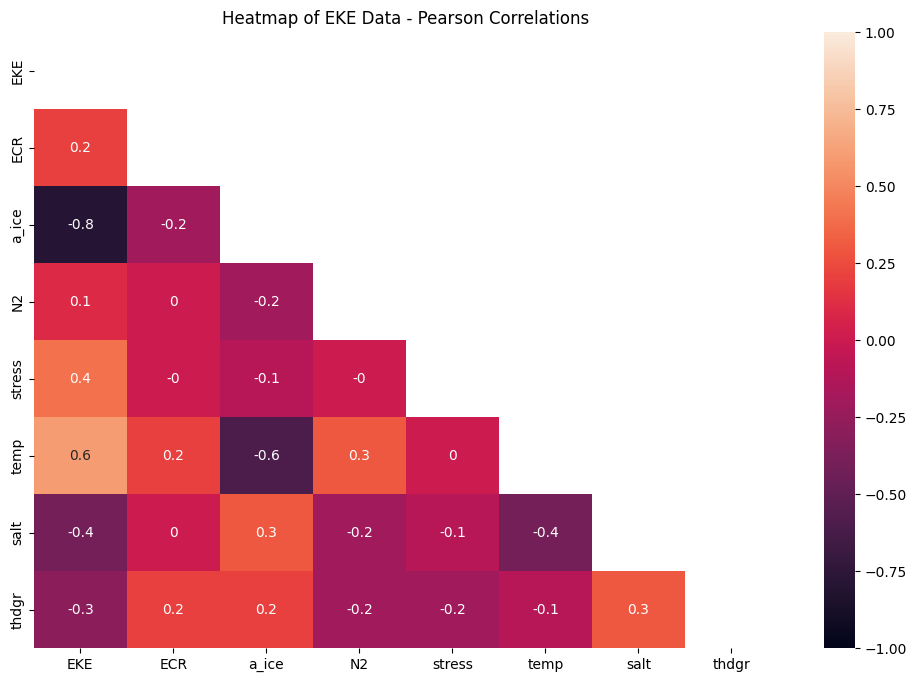

In [64]:
%matplotlib inline

top = 0
bottom = 50
iz = (z1>=top)&(z1<=bottom)
iz1 = (z>=top)&(z<=bottom)
fi = True
EKE_anom_mean=EKE_anom[:,iz].mean(axis=1)
ECR_anom_mean=ECR_anom[:,iz1].mean(axis=1)
N2_anom_mean=N2_anom[:,iz1].max(axis=1)
Temp_anom_mean=temp_anom[:,iz].mean(axis=1)
Salt_anom_mean=salt_anom[:,iz].mean(axis=1)



tmp = np.stack([EKE_anom_mean.values,ECR_anom_mean.values,a_ice_anom.values,N2_anom_mean.values,stress_anom.values,Temp_anom_mean.values,Salt_anom_mean.values,thdgr_anom.values])
df = pd.DataFrame(tmp.T, columns = ['EKE','ECR','a_ice','N2','stress','temp','salt','thdgr'])
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
correlations = df.corr()
correlations=(correlations*10).round()/10
# annot=True displays the correlation values
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, mask=mask, vmin=-1, vmax=1).set(title='Heatmap of EKE Data - Pearson Correlations');

# for var in vars:
#     plt.figure(figsize=(12,8)) # Creating a rectangle (figure) for each plot
#     # Regression Plot also by default includes
#     # best-fitting regression line
#     # which can be turned off via `fit_reg=False`
#     sns.regplot(x=var, y='EKE', data=tmp).set(title=f'Regression plot of {var} and EKE');

In [84]:
#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('EKE ~ ECR+a_ice+stress', data=df, return_type='dataframe')
#y, X = dmatrices('EKE ~ ECR+a_ice+N2', data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [67]:
y, X = dmatrices('EKE ~ ECR+a_ice+stress', data=df, return_type='dataframe')
arima_model = sm.tsa.ARIMA(y, order=(1, 0, 1))
arima_result = arima_model.fit()

# Create an OLS (Ordinary Least Squares) model with the predictor variables
#X = sm.add_constant(X)  # Add a constant for the intercept
ols_model = sm.OLS(arima_result.resid, X)
ols_result = ols_model.fit()
# Print the summary of the multiple linear regression results
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     21.36
Date:                Wed, 08 Nov 2023   Prob (F-statistic):           7.39e-10
Time:                        12:41:31   Log-Likelihood:                 568.73
No. Observations:                  72   AIC:                            -1129.
Df Residuals:                      68   BIC:                            -1120.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.603e-07   1.09e-05      0.033      0.9

/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


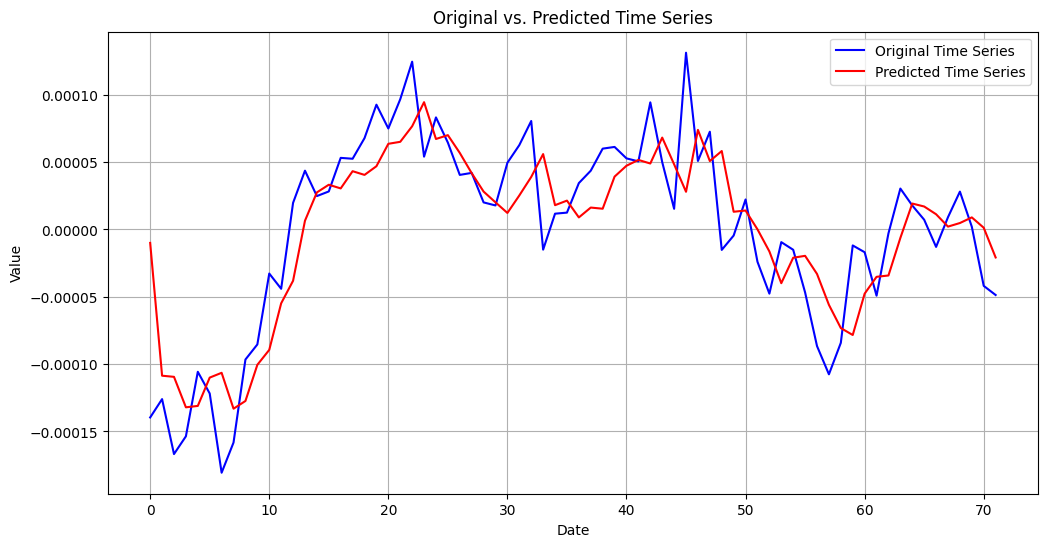

In [61]:
predicted_values = arima_result.predict(typ='levels')

plt.figure(figsize=(12, 6))
plt.plot(y, label='Original Time Series', color='blue')
plt.plot(predicted_values, label='Predicted Time Series', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.title('Original vs. Predicted Time Series')
plt.grid()
plt.show()

In [85]:
vif.round(2)

,VIF,variable
0,1.00,Intercept
1,1.03,ECR
2,1.04,a_ice
3,1.01,stress


In [50]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

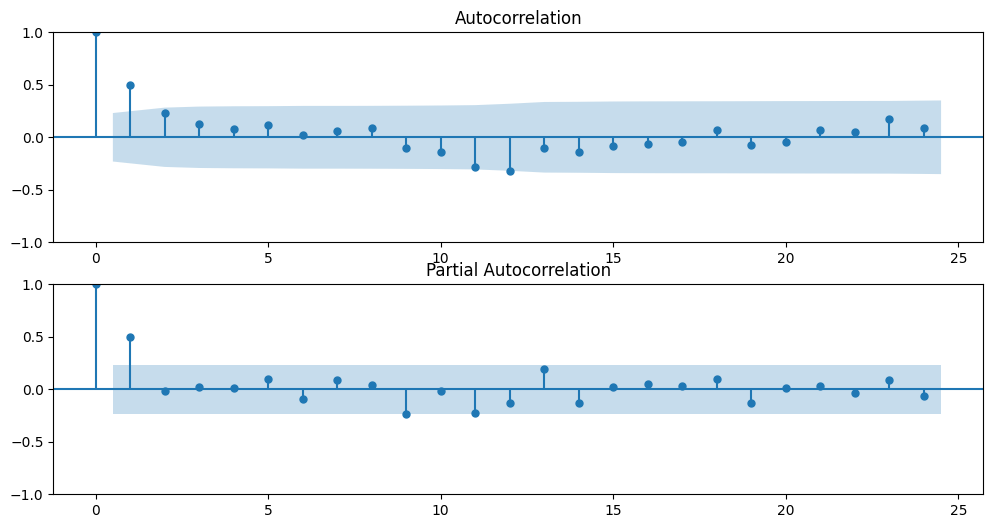

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df['EKE'], ax=ax1, lags=24)
plot_pacf(df['EKE'], ax=ax2, lags=24)
plt.show()

In [14]:
df

,EKE,ECR,a_ice,N2,stress,temp,salt,thdgr
0,-0.000140,-3.323955e-11,0.007685,0.000003,-0.024026,-0.636046,-0.006573,-2.245825e-09
1,-0.000126,-2.503017e-11,0.005734,0.000002,0.028490,-0.615865,-0.005228,-3.205998e-09
2,-0.000167,-4.677195e-11,0.005483,0.000002,-0.017531,-0.595215,-0.003470,-1.258566e-08
3,-0.000154,-4.893707e-11,0.001491,0.000002,0.025730,-0.578998,-0.004441,-6.113346e-09
4,-0.000106,-2.492408e-11,-0.001040,0.000002,-0.024508,-0.556473,-0.002597,5.929551e-09
...,...,...,...,...,...,...,...,...
67,0.000009,2.761355e-11,-0.014161,0.000012,-0.012898,0.489376,-0.007905,-1.073308e-08
68,0.000028,4.383203e-11,-0.150815,0.000013,-0.008312,0.498789,-0.008721,-2.094353e-08
69,0.000002,1.258001e-11,-0.150417,0.000012,-0.000024,0.515494,-0.007346,8.334653e-09
70,-0.000042,-6.490934e-12,-0.032816,0.000011,0.047393,0.534982,-0.005573,-3.267123e-09


In [92]:
y, X = dmatrices('EKE ~ a_ice', data=df, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())

y, X = dmatrices('EKE ~ a_ice+stress', data=df, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())

y, X = dmatrices('EKE ~ a_ice+stress+ECR', data=df, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    EKE   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     111.9
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           3.70e-16
Time:                        19:43:17   Log-Likelihood:                 568.94
No. Observations:                  72   AIC:                            -1134.
Df Residuals:                      70   BIC:                            -1129.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.769e-20   1.07e-05  -3.52e-15      1.0

In [94]:
y, X = dmatrices('EKE ~ ECR', data=df, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())

y, X = dmatrices('EKE ~ ECR+N2', data=df, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())

y, X = dmatrices('EKE ~ ECR+N2+a_ice', data=df, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    EKE   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     43.27
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           7.29e-09
Time:                        19:47:45   Log-Likelihood:                 602.42
No. Observations:                  72   AIC:                            -1201.
Df Residuals:                      70   BIC:                            -1196.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.547e-21   6.72e-06   5.28e-16      1.0

In [83]:
# Fit a linear regression model

# Perform an F-test
f_test = model.f_test("ECR = 0, a_ice = 0, N2 = 0")
print(f_test)

<F test: F=0.9009042402271976, p=0.41099457403478434, df_denom=68, df_num=2>


/p/project/chhb19/mueller29/miniconda3/envs/pyfesom2/lib/python3.10/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
